In [1]:
import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import roc_curve, auc, roc_auc_score
import seaborn as sns

In [2]:
train = pd.read_csv('C:/Users/Mrsoning/OneDrive/Документы/GitHub/Intensive_two/data/train.csv')
test = pd.read_csv('C:/Users/Mrsoning/OneDrive/Документы/GitHub/Intensive_two/data/valid.csv')

C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_11324\3804564391.py:1: DtypeWarning: Columns (51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,131,132,133,135,136,139,140,141,142,143,144,145,146,147,148,149,151,152,155,156,157,158,159,160,161,163,164,165,167,168,169,171,172,173,174,175,176,177,178,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,223,224,227,239,240,241,242,243,244,245,246,459,460,461,467,468,469,515,516,523,524,531,532,539,540,547,548,555,556,563,564,565,567,571,572,573,575,579,580,581,582,583,587,588,595,596,603,604,611,612,613,615,795,796,797,799,1031,1032,1033,1034,1035,1036,1037,1039,1040,1041,1042,1043,1044,1045,1047,1048,1049,1050,1051,1052,1055,1056,1057,1058,1059,1060,1063,1064,1065,1067,1068,1069,1072,1073,1074,1075,1076,1077,1078,1172,1173,1174,1176,1177,1178,1179,1180,1181,1182,1275,1276,1277,1278,1279,1280,1281,1282,1447,1448,1449,

In [3]:
train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14456 entries, 0 to 14455
Columns: 2666 entries, report_date to col2663
dtypes: float64(2316), int64(3), object(347)
memory usage: 294.0+ MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3642 entries, 0 to 3641
Columns: 2666 entries, report_date to col2663
dtypes: float64(2329), int64(3), object(334)
memory usage: 74.1+ MB


In [5]:
train.head()
test.head()

,report_date,client_id,target,col1,col2,col3,col4,col5,col6,col7,...,col2654,col2655,col2656,col2657,col2658,col2659,col2660,col2661,col2662,col2663
0,2023-04-01,2,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,4941670.0,4941670.0,4941670.0,NaN,NaN,NaN,4941670.0,4941670.0,4941670.0,0.256919
1,2023-05-01,4,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11789500.0,11789500.0,11789500.0,NaN,NaN,NaN,11789500.0,11789500.0,11789500.0,0.267221
2,2023-05-01,9,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7000000.0,7000000.0,7000000.0,NaN,NaN,NaN,7000000.0,7000000.0,7000000.0,0.257217
3,2023-03-01,12,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.256261
4,2023-03-01,14,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,10391000.0,10391000.0,10391000.0,0.257348


In [6]:
# Проверка пропусков
train.isnull().sum()
test.isnull().sum()

report_date       0
client_id         0
target            0
col1           3642
col2           3640
               ... 
col2659        3578
col2660        1280
col2661        1280
col2662        1280
col2663           0
Length: 2666, dtype: int64

<Axes: >

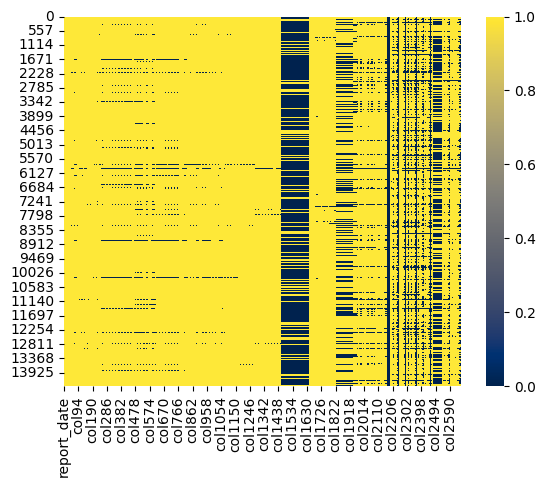

In [7]:
# Проверка пропусков в таблице train
sns.heatmap(train.isnull(),cmap='cividis')

<Axes: >

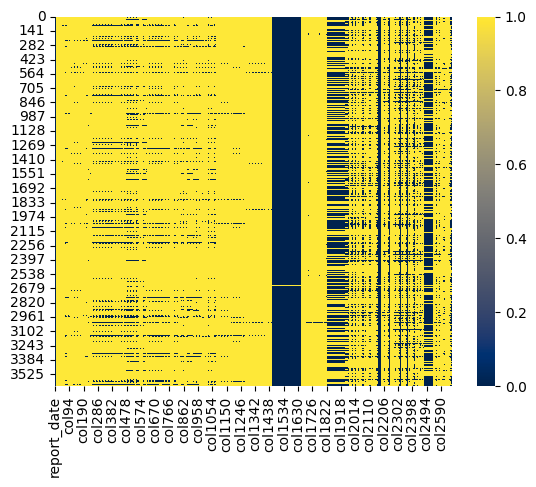

In [8]:
# Проверка пропусков в таблице test
sns.heatmap(test.isnull(),cmap='cividis')

In [9]:
# Отчистка данных для train 
threshold_drop = 0.7

# Удаление столбцов с большим количеством NaN значений в зависимости от класса 'target'
nan_df_cls1 = train[train["target"] == 1].isna().sum()
nan_df_cls0 = train[train["target"] == 0].isna().sum()

# Вычисляем количество объектов в каждом классе
count_cls1 = len(train[train["target"] == 1] )
count_cls0 = len(train[train["target"] == 0] )

# Определяем столбцы, которые нужно удалить для каждого класса, если NaN значений больше, чем порог
drop_col_cls1 =  nan_df_cls1[nan_df_cls1 > count_cls1*threshold_drop]
drop_col_cls0 =  nan_df_cls0[nan_df_cls0 > count_cls0*threshold_drop]

# Находим пересечение столбцов, подлежащих удалению для обоих классов
drop_columns = set(drop_col_cls1.index)&set(drop_col_cls0.index)

# Удаляем найденные столбцы из DataFrame
train = train.drop(columns=drop_columns, errors='ignore')
train.shape


(14456, 543)

In [10]:
# Определение целевой переменной, даты отчета и id клиента
target_column = 'target'
report_date_column = 'report_date'
id_client_columns = ["col1454", "client_id"]

# Создаем список всех признаков, исключая таргет, дату и id клиента
feature_columns = list(set(train.columns) - set([report_date_column]) - set([target_column]) - set(id_client_columns))

# Инициализируем список для хранения константных признаков
constant_features = []

# Проходимся по всем признакам
for column in feature_columns:

    if len(train[column].value_counts()) == 1:
        constant_features.append(column)

# Удаляем константные признаки из DataFrame
train = train.drop(columns=constant_features, errors='ignore')
feature_columns = list(set(feature_columns) - set(constant_features))

In [11]:
# Определяем категориальные признаки как признаки с типом 'object'
not_num_feature_columns = train.select_dtypes('object').columns
not_num_feature_columns = list(set(not_num_feature_columns)&set(feature_columns))
num_feature_columns = list(set(feature_columns) - set(not_num_feature_columns))

# Обновляем список всех признаков, исключая категориальные, тк их обработаем позже
feature_columns = list(set(feature_columns) - set(not_num_feature_columns))

# Очищаем список категориальных колонок - они нам больше не нужны
not_num_feature_columns = []
train.shape

# Проверка количества уникальных значений в числовых признаках
check_cardinality = train[num_feature_columns].apply(lambda x: x.nunique())
number_columns = list(check_cardinality[check_cardinality > 200].index)

# Категориальные признаки
cat_columns = not_num_feature_columns

# Выделяем все числовые колонки, кроме колонок с большим кол-вом уникальных значений, и категориальных
other_columns = list(set(num_feature_columns) - set(number_columns) - set(cat_columns))

# Для всех категориальных колонок - заполняем пропуски значением "unknown"
for cat_col in cat_columns:
    train[cat_col] = train[cat_col].fillna("unknown").astype(str)

# Для числовых колонок с большим количеством уникальных значений - заполняем пропуски медианой
for num_col in number_columns:
    train[num_col] = train[num_col].fillna(train[num_col].median())

# Для всех остальных колонок - заполняем пропуски модой
for other_col in other_columns:
    train[other_col] = train[other_col].fillna(train[other_col].value_counts().index[0])

# Импьютер для числовых данных
imputer = SimpleImputer(strategy='median')


# Преобразование числовых данных
train_numeric = pd.DataFrame(imputer.fit_transform(train[num_feature_columns]), columns=num_feature_columns)
test_numeric = pd.DataFrame(imputer.transform(test[num_feature_columns]), columns=num_feature_columns)



In [12]:
# Отчистка данных для test
threshold_drop = 0.7

# Удаление столбцов с большим количеством NaN значений в зависимости от класса 'target'
nan_df_cls1 = test[test["target"] == 1].isna().sum()
nan_df_cls0 = test[test["target"] == 0].isna().sum()

# Вычисляем количество объектов в каждом классе
count_cls1 = len(test[test["target"] == 1] )
count_cls0 = len(test[test["target"] == 0] )

# Определяем столбцы, которые нужно удалить для каждого класса, если NaN значений больше, чем порог
drop_col_cls1 =  nan_df_cls1[nan_df_cls1 > count_cls1*threshold_drop]
drop_col_cls0 =  nan_df_cls0[nan_df_cls0 > count_cls0*threshold_drop]

# Находим пересечение столбцов, подлежащих удалению для обоих классов
drop_columns = set(drop_col_cls1.index)&set(drop_col_cls0.index)

# Удаляем найденные столбцы из DataFrame
test = test.drop(columns=drop_columns, errors='ignore')
test.shape

(3642, 594)

In [13]:
# Определение целевой переменной, даты отчета и id клиента
target_column = 'target'
report_date_column = 'report_date'
id_client_columns = ["col1454", "client_id"]

# Создаем список всех признаков, исключая таргет, дату и id клиента
feature_columns = list(set(test.columns) - set([report_date_column]) - set([target_column]) - set(id_client_columns))

# Инициализируем список для хранения константных признаков
constant_features = []

# Проходимся по всем признакам
for column in feature_columns:

    if len(test[column].value_counts()) == 1:
        constant_features.append(column)

# Удаляем константные признаки из DataFrame
test = test.drop(columns=constant_features, errors='ignore')
feature_columns = list(set(feature_columns) - set(constant_features))

In [14]:
# Определяем категориальные признаки как признаки с типом 'object'
not_num_feature_columns = test.select_dtypes('object').columns
not_num_feature_columns = list(set(not_num_feature_columns)&set(feature_columns))
num_feature_columns = list(set(feature_columns) - set(not_num_feature_columns))

# Обновляем список всех признаков, исключая категориальные, тк их обработаем позже
feature_columns = list(set(feature_columns) - set(not_num_feature_columns))

# Очищаем список категориальных колонок - они нам больше не нужны
not_num_feature_columns = []
test.shape

# Проверка количества уникальных значений в числовых признаках
check_cardinality = test[num_feature_columns].apply(lambda x: x.nunique())
number_columns = list(check_cardinality[check_cardinality > 200].index)

# Категориальные признаки
cat_columns = not_num_feature_columns

# Выделяем все числовые колонки, кроме колонок с большим кол-вом уникальных значений, и категориальных
other_columns = list(set(num_feature_columns) - set(number_columns) - set(cat_columns))

# Для всех категориальных колонок - заполняем пропуски значением "unknown"
for cat_col in cat_columns:
    test[cat_col] = test[cat_col].fillna("unknown").astype(str)
    
# Для числовых колонок с большим количеством уникальных значений - заполняем пропуски медианой
for num_col in number_columns:
    test[num_col] = test[num_col].fillna(test[num_col].median())

# Для всех остальных колонок - заполняем пропуски модой
for other_col in other_columns:
    test[other_col] = test[other_col].fillna(test[other_col].value_counts().index[0])
    



<Axes: >

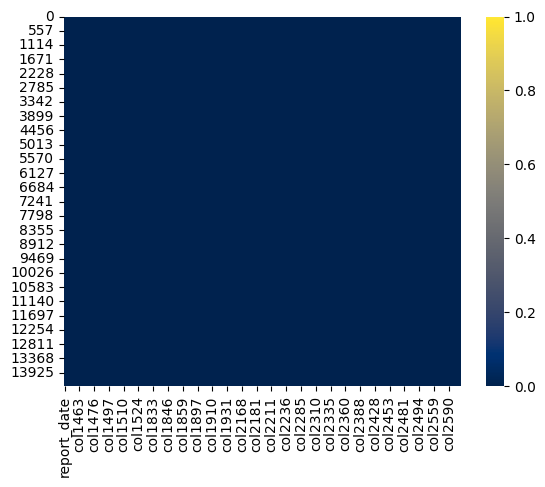

In [15]:
# Проверка на отчистку данных train
sns.heatmap(train.isnull(),cmap='cividis')

<Axes: >

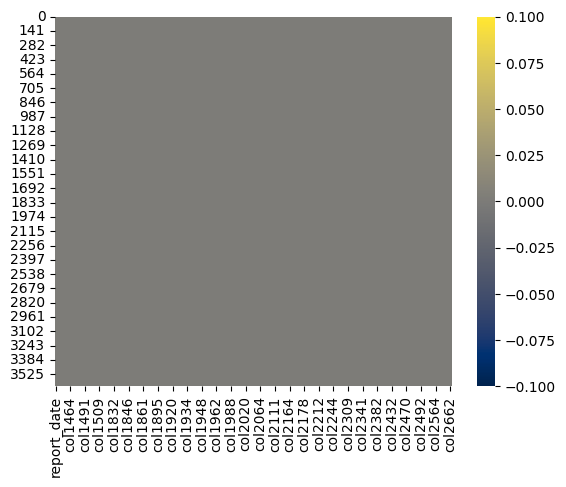

In [16]:
# Проверка на отчистку данных test
sns.heatmap(test.isnull(),cmap='cividis')

In [ ]:
# Подготовка данных для балансировки
X = train_numeric.drop(columns=['target'], errors='ignore')
y = train['target']

# Балансировка классов с использованием SMOTE
smote = SMOTE(random_state=42)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"Распределение классов после SMOTE:\n{pd.Series(y_balanced).value_counts()}")


KeyError: "['col2037', 'col2086', 'col1961', 'col1874', 'col1990', 'col2135', 'col1974', 'col1957', 'col1952', 'col1991', 'col1964', 'col2016', 'col2117', 'col1878', 'col2087', 'col2062', 'col2112', 'col2166', 'col2012', 'col1875', 'col2110', 'col2160', 'col2014', 'col1969', 'col1945', 'col2093', 'col2118', 'col2158', 'col2084', 'col2136', 'col1973', 'col1966', 'col2045', 'col1967', 'col2088', 'col1971', 'col1950', 'col1968', 'col1972', 'col1996', 'col2134', 'col1947', 'col2141', 'col1959', 'col2064', 'col2040', 'col1956', 'col2111', 'col1955', 'col2142', 'col2083', 'col1962', 'col1948', 'col2013', 'col1946', 'col2044', 'col2085', 'col1988', 'col2092', 'col1965', 'col1954', 'col1997', 'col1949', 'col1998', 'col1943', 'col1960', 'col2035', 'col2069', 'col2020', 'col1953', 'col1970', 'col2011', 'col2039', 'col2116', 'col1992', 'col1963', 'col2070', 'col1876', 'col1863', 'col2140', 'col2022', 'col2068', 'col2094', 'col1944', 'col2036', 'col2046', 'col2015', 'col1951', 'col1958', 'col2165', 'col2021', 'col2038', 'col2063', 'col2164', 'col2159', 'col1987', 'col1989'] not in index"

In [18]:
# Выделение категориальных признаков
categorical_columns = train.select_dtypes(include=['object']).columns

# Заполнение пропусков в категориальных данных
from sklearn.impute import SimpleImputer
imputer_cat = SimpleImputer(strategy='most_frequent')  # Заполнение наиболее частыми значениями
train[categorical_columns] = imputer_cat.fit_transform(train[categorical_columns])
test[categorical_columns] = imputer_cat.transform(test[categorical_columns])

# Преобразование категориальных данных в строки
train[categorical_columns] = train[categorical_columns].astype(str)
test[categorical_columns] = test[categorical_columns].astype(str)

# One-Hot Encoding для категориальных признаков
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Кодирование категориальных признаков
X_encoded = encoder.fit_transform(train[categorical_columns])
test_encoded = encoder.transform(test[categorical_columns])

print(f"Train encoded shape: {X_encoded.shape}")
print(f"Test encoded shape: {test_encoded.shape}")



Train encoded shape: (14456, 4842)
Test encoded shape: (3642, 4842)


In [19]:
# Выравниваем столбцы тестовых данных под обучающие
test_numeric = test_numeric[X_balanced.columns]

# Масштабирование числовых признаков
scaler = StandardScaler()

# Применяем масштабирование
X_train_scaled = scaler.fit_transform(X_balanced)
X_test_scaled = scaler.transform(test_numeric)

print(f"Train scaled shape: {X_train_scaled.shape}")
print(f"Test scaled shape: {X_test_scaled.shape}")


Train scaled shape: (28040, 345)
Test scaled shape: (3642, 345)


In [20]:
# Пример добавления временных признаков
train['report_date'] = pd.to_datetime(train['report_date'])
test['report_date'] = pd.to_datetime(test['report_date'])

train['month'] = train['report_date'].dt.month
train['quarter'] = train['report_date'].dt.quarter

test['month'] = test['report_date'].dt.month
test['quarter'] = test['report_date'].dt.quarter

# Пример агрегатов
train['mean_value'] = train_numeric.mean(axis=1)
test['mean_value'] = test_numeric.mean(axis=1)


C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_16256\3361450543.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['month'] = train['report_date'].dt.month
C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_16256\3361450543.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  train['quarter'] = train['report_date'].dt.quarter
C:\Users\Mrsoning\AppData\Local\Temp\ipykernel_16256\3361450543.py:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor p

In [21]:
# Финальное разделение данных
X_final = train_numeric.drop(columns=['target'], errors='ignore')
y_final = train['target']

X_train_final, X_val_final, y_train_final, y_val_final = train_test_split(
    X_final, y_final, test_size=0.2, random_state=42, stratify=y_final
)

print("Обучающая выборка готова к моделированию!")
print(f"Train shape: {X_train_final.shape}, Validation shape: {X_val_final.shape}")


Обучающая выборка готова к моделированию!
Train shape: (11564, 345), Validation shape: (2892, 345)


In [22]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt

# Обучение базовой модели RandomForest
model = RandomForestClassifier(random_state=42)
model.fit(X_train_final, y_train_final)

# Оценка важности признаков
feature_importances = model.feature_importances_
feature_names = X_train_final.columns


In [23]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier

# Логистическая регрессия
log_reg = LogisticRegression(max_iter=1000, random_state=42)
log_reg_scores = cross_val_score(log_reg, X_train_final, y_train_final, cv=5, scoring='roc_auc')
print(f"Logistic Regression ROC-AUC: {log_reg_scores.mean():.4f}")

# Градиентный бустинг
gbc = GradientBoostingClassifier(random_state=42)
gbc_scores = cross_val_score(gbc, X_train_final, y_train_final, cv=5, scoring='roc_auc')
print(f"Gradient Boosting ROC-AUC: {gbc_scores.mean():.4f}")

# Случайный лес
rf_scores = cross_val_score(model, X_train_final, y_train_final, cv=5, scoring='roc_auc')
print(f"Random Forest ROC-AUC: {rf_scores.mean():.4f}")


c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:\Python\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
c:

Logistic Regression ROC-AUC: 0.6597
Gradient Boosting ROC-AUC: 0.8810
Random Forest ROC-AUC: 0.9311


In [24]:
from sklearn.model_selection import GridSearchCV

# Параметры для GridSearch
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, scoring='roc_auc', verbose=1)
grid_search.fit(X_train_final, y_train_final)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"ROC-AUC на обучении: {grid_search.best_score_:.4f}")

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Лучшие параметры: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
ROC-AUC на обучении: 0.8976


ROC-AUC на валидации: 0.9229


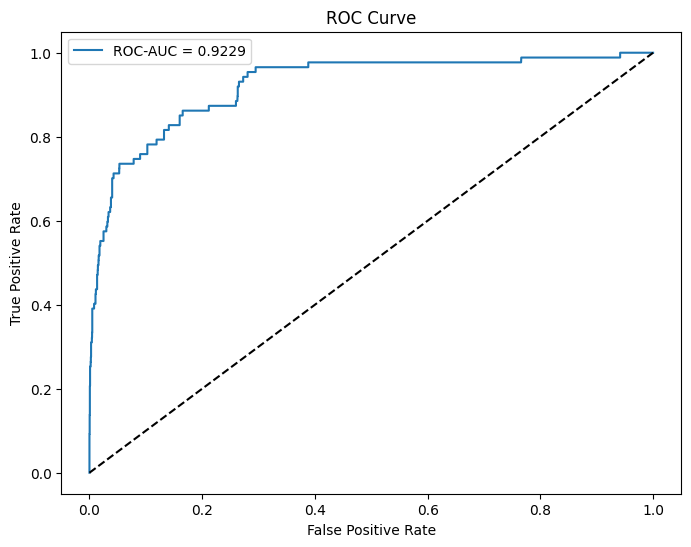

In [25]:
# Лучшая модель
best_model = grid_search.best_estimator_

# Предсказания и оценка
from sklearn.metrics import roc_auc_score, roc_curve

y_val_pred = best_model.predict_proba(X_val_final)[:, 1]
roc_auc = roc_auc_score(y_val_final, y_val_pred)
print(f"ROC-AUC на валидации: {roc_auc:.4f}")

# ROC-кривая
fpr, tpr, _ = roc_curve(y_val_final, y_val_pred)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'ROC-AUC = {roc_auc:.4f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

In [26]:
# Предсказания на тестовых данных
test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]

# Сохранение результата
submission = pd.DataFrame({
    'client_id': test['client_id'],
    'score': test_predictions
})
submission.to_csv('submission_file.csv', index=False)

print("Результат сохранён в submission_file.csv")


Результат сохранён в submission_file.csv


c:\Python\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [27]:
from sklearn.metrics import roc_auc_score, classification_report

# Предсказания на валидационном наборе
y_val_pred = best_model.predict_proba(X_val_final)[:, 1]

# Оценка ROC-AUC
roc_auc = roc_auc_score(y_val_final, y_val_pred)
print(f"ROC-AUC на валидации: {roc_auc:.4f}")

# Подробный отчет по классификации
threshold = 0.5  # Используем стандартный порог
y_val_class = (y_val_pred >= threshold).astype(int)
print(classification_report(y_val_final, y_val_class))


ROC-AUC на валидации: 0.9229
              precision    recall  f1-score   support

           0       0.97      1.00      0.99      2805
           1       0.90      0.10      0.19        87

    accuracy                           0.97      2892
   macro avg       0.94      0.55      0.59      2892
weighted avg       0.97      0.97      0.96      2892



In [28]:
# Предсказания на обучающем наборе
y_train_pred = best_model.predict_proba(X_train_final)[:, 1]
train_roc_auc = roc_auc_score(y_train_final, y_train_pred)

print(f"ROC-AUC на обучении: {train_roc_auc:.4f}")
print(f"Разница ROC-AUC между обучением и валидацией: {train_roc_auc - roc_auc:.4f}")


ROC-AUC на обучении: 0.9839
Разница ROC-AUC между обучением и валидацией: 0.0610


In [29]:
# Предсказания для тестового набора
test_predictions = best_model.predict_proba(X_test_scaled)[:, 1]


c:\Python\Lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


In [30]:
# Создание файла для отправки
submission = pd.DataFrame({
    'client_id': test['client_id'],
    'score': test_predictions
})

# Сохранение файла
submission.to_csv('submission_file.csv', index=False)
print("Результат сохранён в submission_file.csv")


Результат сохранён в submission_file.csv


In [31]:
# Проверка первых строк файла
print(submission.head())

# Проверка на наличие пропусков
print(submission.isnull().sum())


   client_id     score
0          2  0.423432
1          4  0.492418
2          9  0.437400
3         12  0.423432
4         14  0.423432
client_id    0
score        0
dtype: int64
